<b>Human Segmentation</b>  
1. 사진 3장 이상을 Semantic Segmentation으로 배경과 분리  
2. blurring 기술로 배경을 흐리게 처리  
3. 피사체를 배경의 원래 위치에 합성  
4. 사진 1장 이상을 chromakey 기법으로 다른 배경과 합성  
  
<b>image segmentation이란?</b>  
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법  
모든 픽셀에 label을 할당하고 같은 label은 공통적인 특징을 가진다고 가정  
  
<b>semantic segmentation이란?</b>  
이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법  

In [1]:
import os
import urllib #웹에서 데이터를 다운로드 할 때 사용
import cv2 #opencv 라이브러리
import numpy as np
from pixellib.semantic import semantic_segmentation #semantic segmentation 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

<b>사진1. 레드벨벳 슬기 사진으로 semantic segmentation</b>

(400, 600, 3)


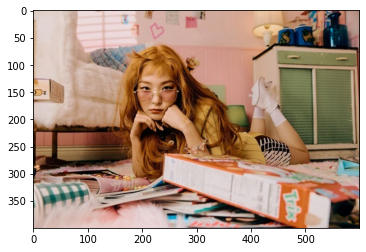

In [3]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
person_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image.png'  
person_img_orig = cv2.imread(person_img_path) 

print(person_img_orig.shape)
plt.imshow(cv2.cvtColor(person_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

<b>PixelLib에서 제공해 주는 모델을 다운로드</b>

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f1023322340>)

<b>PixelLib로 세그멘테이션 모델을 생성</b>

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

<b>model에 이미지 입력</b>  
deeplabv3는 PASCAL VOC 데이터로 학습된 모델을 이용  
segvalues는 class_ids, masks 있음  
output는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있음  

In [27]:
person_segvalues, person_output = model.segmentAsPascalvoc(person_img_path)

<b>PASCAL VOC 데이터 label 종류</b>  
background 제외하면 20개 클래스 있음

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

<b>모델에서 나온 출력값</b>

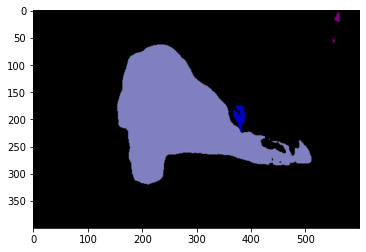

In [28]:
plt.imshow(person_output)
plt.show()

In [10]:
person_segvalues

{'class_ids': array([ 0,  5,  9, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [11]:
#class_id를 통해 어떤 물체가 담겨 있는지 알 수 있다
for class_id in person_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
chair
person
sofa


In [13]:
#각 물체마다 output에 어떤 색상으로 나타나 있는지 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [14]:
colormap[15] #사람의 색상, BGR 순서로 채널 배치 

array([192, 128, 128])

In [15]:
seg_color = (128,128,192)#RGB 순서로 바꿔줌 

(400, 600)


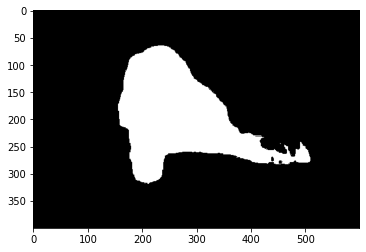

In [16]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
#즉 물체가 있는 위치는 1, 그 외에는 0
person_seg_map = np.all(person_output==seg_color, axis=-1)
print(person_seg_map.shape)
plt.imshow(person_seg_map, cmap='gray')
plt.show()

<b>원래 이미지와 불리한 객체 겹쳐보기</b>

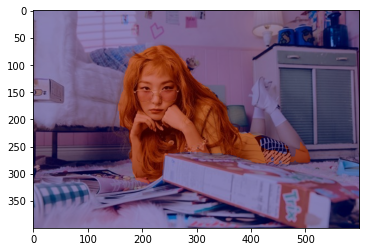

In [17]:
person_img_show = person_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
person_img_mask = person_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
person_color_mask = cv2.applyColorMap(person_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
person_img_show = cv2.addWeighted(person_img_show, 0.6, person_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(person_img_show, cv2.COLOR_BGR2RGB))
plt.show()

<b>배경 blurring 처리</b>

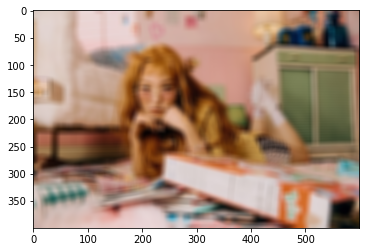

In [18]:
# (13,13)은 blurring kernel size
img_orig_blur = cv2.blur(person_img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

<b>배경 추출</b> 

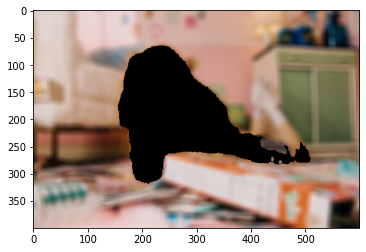

In [19]:
person_img_mask_color = cv2.cvtColor(person_img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(person_img_mask_color) #이미지 반전됨=>255:배경, 0:사람
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) #배경만 있는 영상 얻을 수 있음 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

<b>배경과 원본 합성</b>  
np.where(조건, 참일 때, 거짓일 때), 255인 부분만 원본 이미지 값 가져오고 아닌 영역은 blur 이미지 가져옴 

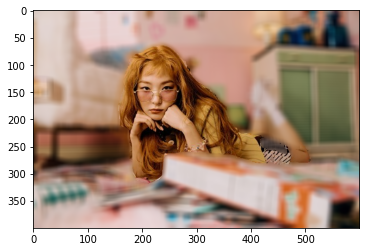

In [20]:
person_img_concat = np.where(person_img_mask_color==255, person_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(person_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

<b>문제점</b>  
1.해당 합성 사진에서 가장 큰 문제점은 모델의 다리가 segmentation 안되었다는 점이다.  
추측하건데 deeplabv3는 PASCAL VOC data에 있는 이미지와 레이블을 기반으로 판단하기 때문에 해당 사진에서 모델이 취한 포즈와 비슷한 이미지데이터가 없거나 부족해서 완전한 segmentaion을 못한게 아닐까 싶다.  
  
2.두번째 문제점은 해당 사진에 chair와 bottle이 없는 것 같은데 신경망이 있다고 인식한 점이다.  
아마 뒤에 있는 캐비넷을 의자로 인식한게 아닐까 싶다.  
실제로는 다른 물건이나 PASCAL VOC의 label과 비슷한 색상 값을 가지면 label에 있는 물체로 인식했다.  
  
<b>해결방안</b>  
1. 이미지 전처리 과정에서 augmentation을 추가하여 데이터 수를 증가시켜 신경망이 더 다양한 표현을 학습할 수 있게 해준다.  
2. deeplabv3이 PASCAL VOC가 아닌 다른 human pose data를 학습하게 한다.  
PASCAL VOC의 train data는 5717개인데 이 안에 label에 21개의 label에 해당하는 사진들이 있기 때문에 사람의 포즈를 학습하기에 부족할 수 있다.  
따라서 human image dataset을 웹상에서 다운받아 deeplabv3이 학습한다면 인식하지 못한 종아리 부분을 분리할 수도 있다.  
검색을 해보니 Deelvine이라는 회사에서 40,000개 이상의 이미지를 가진 human image dataset을 자체적으로 만들었는데 이 데이터셋을 사용하면 
위 문제를 해결할 수 있을 것이다.  
3.deeplabv3말고 좀 더 섬세하게 segmentation 가능한 U-net 같은 모델을 활용한다.  
정밀하고 섬세한 segmentation을 요구하는 의료영상에서 자주 쓰이는 U-net을 활용하면 종아리도 신체의 일부로 판단할 수 있을 것 같다.  

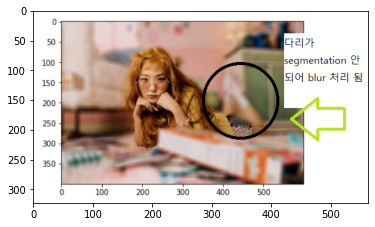

In [22]:
pb1_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/person.png'  
pb1_img_orig = cv2.imread(pb1_img_path) 

plt.imshow(cv2.cvtColor(pb1_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

<b>사진2. 강아지와 사람을 함께 segmantation하기</b> 

(360, 539, 3)


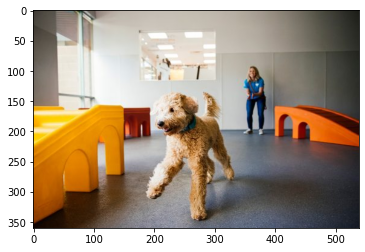

In [24]:
dog_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dogandperson2.png'  
dog_img_orig = cv2.imread(dog_img_path) 

print(dog_img_orig.shape)
plt.imshow(cv2.cvtColor(dog_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
dog_segvalues, dog_output = model.segmentAsPascalvoc(dog_img_path)

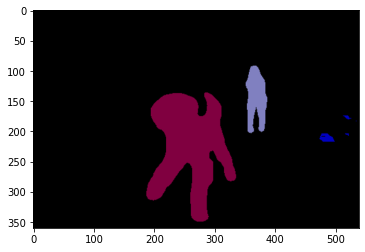

In [26]:
#출력값 확인
plt.imshow(dog_output)
plt.show()

In [29]:
#class_id를 통해 어떤 물체가 담겨 있는지 알 수 있다
for class_id in dog_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
dog
person


In [32]:
print("dog:{}, person:{}".format(colormap[12], colormap[15]))

dog:[ 64   0 128], person:[192 128 128]


In [34]:
dog_seg_color = (128,0,64)#RGB 순서로 바꿔줌 
person_seg_color = (128, 128, 192)

(360, 539)


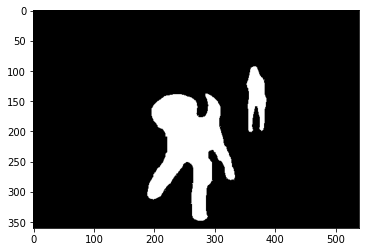

In [35]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
#즉 물체가 있는 위치는 1, 그 외에는 0
dog_seg_map = np.all((dog_output==dog_seg_color)|(dog_output==person_seg_color), axis=-1)
print(dog_seg_map.shape)
plt.imshow(dog_seg_map, cmap='gray')
plt.show()

<b>원래 이미지와 분리한 이미지 합치기</b>

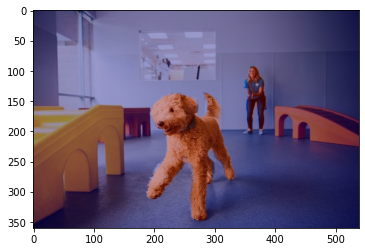

In [36]:
dog_img_show = dog_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
dog_img_mask = dog_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
dog_color_mask = cv2.applyColorMap(dog_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
dog_img_show = cv2.addWeighted(dog_img_show, 0.6, dog_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dog_img_show, cv2.COLOR_BGR2RGB))
plt.show()

<b>image blurring 처리</b>

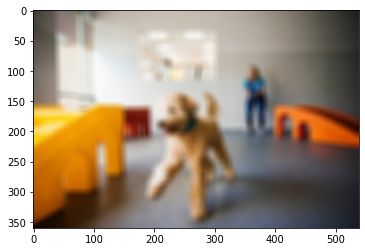

In [37]:
# (13,13)은 blurring kernel size
dog_img_orig_blur = cv2.blur(dog_img_orig, (13,13))  
plt.imshow(cv2.cvtColor(dog_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

<b>사람하고 강아지 빼고 배경 추출</b>

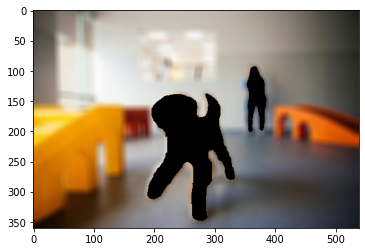

In [38]:
dog_img_mask_color = cv2.cvtColor(dog_img_mask, cv2.COLOR_GRAY2BGR)
dog_img_bg_mask = cv2.bitwise_not(dog_img_mask_color) #이미지 반전됨=>255:배경, 0:사람
dog_img_bg_blur = cv2.bitwise_and(dog_img_orig_blur, dog_img_bg_mask) #배경만 있는 영상 얻을 수 있음 
plt.imshow(cv2.cvtColor(dog_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

<b>배경하고 원본 합성</b> 

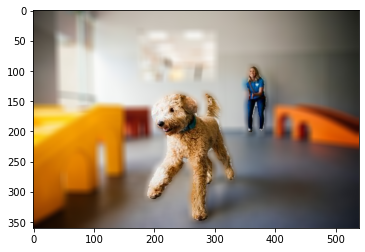

In [39]:
dog_img_concat = np.where(dog_img_mask_color==255, dog_img_orig, dog_img_bg_blur)
plt.imshow(cv2.cvtColor(dog_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

<b>문제점</b>  
사진2의 경우 큰 문제점이 없었다.  
강아지는 꼬리가 잘 분리되었고 윤곽도 잘 분리되어 보인다.  
사람의 경우 왼쪽 팔이 흐릿하게 보이긴 한데 이미지를 키우고 다시 semantic segmentation을 하면 깔끔하게 출력될 것이다.  
한가지 문제점은 강아지용 미끄럼틀이 chair로 인식된 점인데 이는 사진1의 경우 처럼 더 다양한 이미지 dataset을 활용하거나 label을 늘이는 방법을 생각해 볼 수 있다.  

<b>사진3. 크로마키사진</b>  
레드벨벳 웬디와 배경사진을 합성해 크로마키 사진 만들기 

(240, 210, 3)


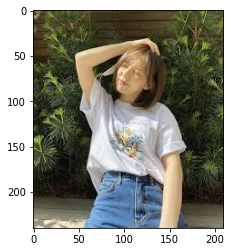

In [40]:
#웬디 사진
ck_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/wendy.png'  
ck_img_orig = cv2.imread(ck_img_path) 

print(ck_img_orig.shape)
plt.imshow(cv2.cvtColor(ck_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(240, 210, 3)


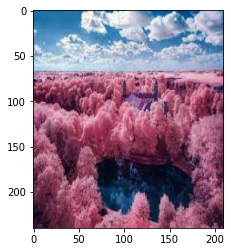

In [44]:
#배경사진 
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  
bg_img_orig = cv2.imread(bg_img_path) 
bg_img_orig = cv2.resize(bg_img_orig, dsize=(210, 240), interpolation=cv2.INTER_AREA) #웬디 사진과  size 일치하도록 resize 

print(bg_img_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
ck_segvalues, ck_output = model.segmentAsPascalvoc(ck_img_path)

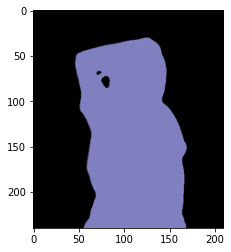

In [46]:
plt.imshow(ck_output)
plt.show()

In [47]:
#class_id를 통해 어떤 물체가 담겨 있는지 알 수 있다
for class_id in ck_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [48]:
ck_seg_color = (128, 128, 192)

(240, 210)


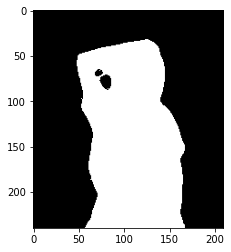

In [50]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
#즉 물체가 있는 위치는 1, 그 외에는 0
ck_seg_map = np.all(ck_output==ck_seg_color, axis=-1)
print(ck_seg_map.shape)
plt.imshow(ck_seg_map, cmap='gray')
plt.show()

<b>원본 이미지와 분리한 이미지 합치기</b> 

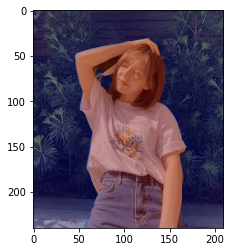

In [51]:
ck_img_show = ck_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
ck_img_mask = ck_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
ck_color_mask = cv2.applyColorMap(ck_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
ck_img_show = cv2.addWeighted(ck_img_show, 0.6, ck_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(ck_img_show, cv2.COLOR_BGR2RGB))
plt.show()

<b>배경사진과 분리된 인물 합성</b> 

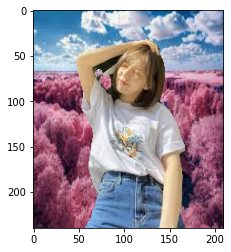

In [55]:
ck_img_mask_color = cv2.cvtColor(ck_img_mask, cv2.COLOR_GRAY2BGR)
ck_img_concat = np.where(ck_img_mask_color==0, bg_img_orig, ck_img_orig) #여기선 사람과 배경 값 바꾸지 않았으므로 사람은 0 배경은 255
plt.imshow(cv2.cvtColor(ck_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

<b>문제점</b>  
헤어라인과 옷 소매쪽이 검게 처리되어 출력되었다.  
해결방안은 아래쪽에서 설명하겠다.  

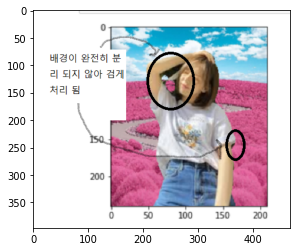

In [56]:
#웬디 사진
pb3_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey.png'  
pb3_img_orig = cv2.imread(pb3_img_path) 

plt.imshow(cv2.cvtColor(pb3_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

<b>해결방안</b>  
medium blog에서 아래의 article을 읽었는데 꽤 흥미로웠다.  
https://medium.com/deelvin-machine-learning/human-image-segmentation-experience-from-deelvin-5148a6cc71da  
  
위에서 언급했듯 Deelvin이란 회사에서 자체적으로 encoder와 decoder를 활용한 모델을 만들었다.  
여러 분리된 이미지를 배경이미지와 합성했을 때 신경망이 머리카락을 잘 해석 못한다는 점을 알아냈다.  
아래의 사진을 보자.
재밌는점은 머리카락이 없는 남성의 경우 완벽하게 segmentation된 모습을 보이지만 여성의 경우 헤어라인에 빈 공간이 함께 합성되었음을 볼 수 있다.  
  
Deelvine은 data augmentation을 추가해 더 많은 사진 data를 만들어내고 이를 신경망이 학습하게해 이러한 문제를 해결했다.  
두 번째 사진은 data augmentation을 한 경우로 헤어라인이 자연스럽게 출력 되었다.  
  
이 article을 읽고 Deelvin 회사의 웹사이트에 접속했다.  
https://bgrem.deelvin.com/remove_video_bg/?params=creator  
  
이 회사의 웹사이트에 들어가서 합성하고 싶은 이미지와 배경이미지를 업로드하면 자체 개발한 모델이 알아서 크로마키 사진을 합성해준다.  
딥러닝을 모르는 사람들도 쉽고 유용하게 이용 가능하다.  
또 이미지 뿐만 아니라 영상도 합성할 수 있다.  
  
나의 경우 웬디 사진과 배경사진을 업로드해 크로마키 사진을 합성하니 꽤 자연스러웠다.  
쉽고 간편하게 이런 사진 합성 서비스를 이용할 수 있다니 딥러닝의 많은 발전을 새삼 다시 느꼈다.  

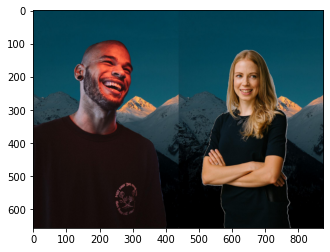

In [57]:
#data augmentation 하기 이전 크로마키 사진 
ck2_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey2.png'  
ck2_img_orig = cv2.imread(ck2_img_path) 

plt.imshow(cv2.cvtColor(ck2_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

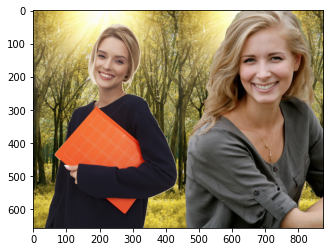

In [58]:
#data augmentation한 사진
ck3_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey3.png'  
ck3_img_orig = cv2.imread(ck3_img_path) 

plt.imshow(cv2.cvtColor(ck3_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

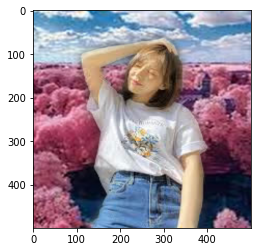

In [64]:
#최종 크로마키 사진
ck4_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chromakey.png'  
ck4_img_orig = cv2.imread(ck4_img_path) 
ck4_img_orig = cv2.resize(ck4_img_orig, dsize=(500, 500), interpolation=cv2.INTER_AREA)

plt.imshow(cv2.cvtColor(ck4_img_orig, cv2.COLOR_BGR2RGB))
plt.show()